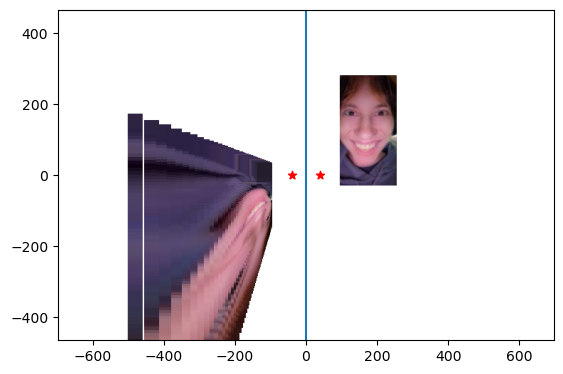

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

#Everything before "image = plt.imread(image)" is just on ellas request, before we actually submit it would be replaced
choice = input("Tall (T) or Wide (W)")
while choice.upper() != "T" and choice.upper() != "W":
    choice = input("Tall (T) or Wide (W)")
if choice.upper() == "T":
    ella_hugo_BOSS_ulbrich = randint(1,22)
    if ella_hugo_BOSS_ulbrich == 7:
        image = "Tall2.jpg"
        #Thales: 80 wide, 134 high
    else:
        image = "Tall1.jpg"
        #Ella: 80 wide, 155 high
else:
    image = "aWide.jpg"
    #164 wide, 80 high

image = plt.imread(image)
scale = 3
size = max(image.shape[0],image.shape[1])*scale
canvas = np.zeros((size, int(size*1.5), image.shape[2]), dtype=np.uint8)
canvas += 255
f = int(0.5*image.shape[1])
start_x = int(0.6*image.shape[1])
start_y = int(-0.9*image.shape[0])
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        colour = image[y, x]
        old_x = x + start_x
        old_y = y + start_y
        new_x = -int((f*old_x) / (old_x-f))
        new_y = int((old_y/old_x)*new_x)
        try:
            canvas[(size//2)+old_y, (3*size//4)+old_x] = colour
        except:
            continue
        for dy in range(-10, 11):
            for dx in range(-10, 11):
                try:
                    canvas[(size//2)+new_y+dy, (3*size//4)+new_x+dx] = colour
                except:
                    continue

plt.imshow(canvas, extent=[-size*1.5, size*1.5, -size, size])
plt.xlim(-size*1.5, size*1.5)
plt.ylim(-size, size)
plt.axvline(x=0)
plt.scatter(f, 0, color='red', marker='*')
plt.scatter(-f, 0, color='red', marker='*')

In [30]:
# interactive code with vectorisation
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from time import perf_counter
import ipywidgets as widgets
from ipywidgets import interact

# --- Task 6 Image Selection ---
choice = input("Tall (T) or Wide (W): ")
while choice.upper() not in ("T", "W"):
    choice = input("Tall (T) or Wide (W): ")

if choice.upper() == "T":
    if randint(1, 22) == 7:
        image_file = "Tall2.jpg"  # Thales: 80 wide, 134 high
    else:
        image_file = "Tall1.jpg"  # Ella: 80 wide, 155 high
else:
    image_file = "aWide.jpg"      # 164 wide, 80 high

# Load the image; assume an RGB image.
image = plt.imread(image_file)
img_height, img_width, channels = image.shape

def update_task6(start_x, start_y, scale, f_val=int(0.5 * img_width)):
    t0 = perf_counter()

    fudge_y = img_height // 2
    start_y += fudge_y
    start_y *= -1

    # Canvas dimensions
    size = max(img_height, img_width) * scale
    canvas_height = size
    canvas_width = int(size * 1.5)
    canvas = np.full((canvas_height, canvas_width, channels), 255, dtype=np.uint8)

    # Create coordinate arrays for the image pixels.
    yy, xx = np.indices((img_height, img_width))
    # Compute object (“old”) coordinates using slider values.
    old_x = xx + start_x
    old_y = yy + start_y

    # Compute projected (virtual) coordinates.
    new_x_float = - (f_val * old_x) / (old_x - f_val)
    new_x = new_x_float.astype(int)
    new_y_float = (old_y / old_x) * new_x_float
    new_y = new_y_float.astype(int)

    # Convert these to canvas indices.
    old_y_index = (canvas_height // 2) + old_y
    old_x_index = (canvas_width // 2) + old_x
    new_y_index = (canvas_height // 2) + new_y
    new_x_index = (canvas_width // 2) + new_x

    # Validity checks.
    valid_old = (old_y_index >= 0) & (old_y_index < canvas_height) & \
                (old_x_index >= 0) & (old_x_index < canvas_width)
    valid_new = (new_y_index >= 0) & (new_y_index < canvas_height) & \
                (new_x_index >= 0) & (new_x_index < canvas_width)

    # Place the pixels.
    canvas[old_y_index[valid_old], old_x_index[valid_old]] = image[yy[valid_old], xx[valid_old]]
    canvas[new_y_index[valid_new], new_x_index[valid_new]] = image[yy[valid_new], xx[valid_new]]

    # Compute bounding box for the new image projection.
    all_new_x = new_x_index[valid_new].ravel()
    all_new_y = new_y_index[valid_new].ravel()
    raw_min_x = int(all_new_x.min())
    raw_max_x = int(all_new_x.max())
    raw_min_y = int(all_new_y.min())
    raw_max_y = int(all_new_y.max())

    minimum_x = max(raw_min_x, 0)
    maximum_x = min(raw_max_x, canvas_width - 1)
    minimum_y = max(raw_min_y, 0)
    maximum_y = min(raw_max_y, canvas_height - 1)

    # --- Interpolation Functions ---
    def fix_row(row, left, right):
        cols = np.arange(left, right+1)
        row_slice = canvas[row, left:right+1]
        mask = (row_slice != 255).any(axis=1)
        if mask.sum() < 2:
            return
        filled_cols = cols[mask]
        seg_left = filled_cols[0]
        seg_right = filled_cols[-1]
        interp_cols = np.arange(seg_left, seg_right+1)
        for ch in range(channels):
            xp = filled_cols
            fp = row_slice[mask, ch]
            interpolated = np.interp(interp_cols, xp, fp)
            canvas[row, interp_cols, ch] = np.around(interpolated).astype(np.uint8)

    def fix_col(col, top, bottom):
        rows = np.arange(top, bottom+1)
        col_slice = canvas[top:bottom+1, col]
        mask = (col_slice != 255).any(axis=1)
        if mask.sum() < 2:
            return
        filled_rows = rows[mask]
        seg_top = filled_rows[0]
        seg_bottom = filled_rows[-1]
        interp_rows = np.arange(seg_top, seg_bottom+1)
        for ch in range(channels):
            xp = filled_rows
            fp = col_slice[mask, ch]
            interpolated = np.interp(interp_rows, xp, fp)
            canvas[interp_rows, col, ch] = np.around(interpolated).astype(np.uint8)

    for col in range(minimum_x, maximum_x+1):
        fix_col(col, minimum_y, maximum_y)
    for row in range(minimum_y, maximum_y+1):
        fix_row(row, minimum_x, maximum_x)

    t_elapsed = perf_counter() - t0
    print("Task 6 processing time: {:.4f} seconds".format(t_elapsed))

    plt.figure(figsize=(8, 6))
    extent_val = [-canvas_width // 2, canvas_width // 2, -canvas_height // 2, canvas_height // 2]
    plt.imshow(canvas, extent=extent_val)
    plt.xlim(extent_val[0], extent_val[1])
    plt.ylim(extent_val[2], extent_val[3])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.scatter(f_val, 0, color='red', marker='*')
    plt.scatter(-f_val, 0, color='red', marker='*')
    plt.title(f"Task 6: start_x = {start_x}, start_y = {start_y}")
    plt.show()

# Define slider ranges (here roughly based on the image dimensions).
slider_range_x = (-int(1 * img_width), int(2.5 * img_width))
slider_range_y = (-int(1.5 * img_height), int(1.5 * img_height))
slider_range_f = (0, int(1.5 * img_height))

# Create widget objects for the interactive controls.
start_x_slider = widgets.IntSlider(
    min=slider_range_x[0], max=slider_range_x[1],
    step=1, value=60, description="start_x"
)
start_y_slider = widgets.IntSlider(
    min=slider_range_y[0], max=slider_range_y[1],
    step=1, value=0, description="start_y"
)
scale_slider = widgets.IntSlider(
    min=1, max=41, step=1, value=7, description="Canvas Scale"
)
f_val_slider = widgets.IntSlider(
    min=slider_range_f[0], max=slider_range_f[1],
    step=1, value=150, description="focal length"
)

# Flags to avoid recursive observer calls.
updating_start_x = False
updating_f_val = False

def on_start_x_change(change):
    global updating_start_x, updating_f_val
    if updating_start_x:
        return
    if change['name'] != 'value':
        return
    new_start_x = change['new']
    current_f_val = f_val_slider.value
    # Check whether the new start_x would put f_val into the forbidden range:
    # i.e. new_start_x <= f_val <= new_start_x + img_width.
    if new_start_x <= current_f_val <= new_start_x + img_width:
        old_value = change['old']
        # Determine the direction: if slider increased, snap above the forbidden zone;
        # if decreased, snap below it.
        if new_start_x > old_value:
            candidate = current_f_val + 1  # Must have start_x > f_val.
        else:
            candidate = current_f_val - img_width - 1  # Must have start_x < f_val - img_width.
        # Clamp candidate to the allowed range.
        candidate = min(max(candidate, start_x_slider.min), start_x_slider.max)
        updating_start_x = True
        start_x_slider.value = candidate
        updating_start_x = False

def on_f_val_change(change):
    global updating_f_val, updating_start_x
    if updating_f_val:
        return
    if change['name'] != 'value':
        return
    new_f_val = change['new']
    current_start_x = start_x_slider.value
    # Check the forbidden condition for f_val given current start_x:
    # current_start_x <= f_val <= current_start_x + img_width.
    if current_start_x <= new_f_val <= current_start_x + img_width:
        old_value = change['old']
        if new_f_val > old_value:
            # Dragging upward: jump just above the forbidden range.
            candidate = current_start_x + img_width + 1
        else:
            # Dragging downward: jump below the forbidden range.
            candidate = current_start_x - 1
        candidate = min(max(candidate, f_val_slider.min), f_val_slider.max)
        updating_f_val = True
        f_val_slider.value = candidate
        updating_f_val = False

# Attach observers to start_x and f_val sliders.
start_x_slider.observe(on_start_x_change, names='value')
f_val_slider.observe(on_f_val_change, names='value')

# Create the interactive UI.
widgets.interact(update_task6, 
                 start_x=start_x_slider,
                 start_y=start_y_slider,
                 scale=scale_slider,
                 f_val=f_val_slider);

interactive(children=(IntSlider(value=60, description='start_x', max=200, min=-80), IntSlider(value=0, descrip…

In [ ]:
T

In [ ]:
T